# 3️⃣ **프로젝트 3: 한국 부동산 시장 분석 및 투자 전략 수립**  
https://rt.molit.go.kr/pt/xls/xls.do?mobileAt=  
**과제 1: 수도권 vs 지방 (or 서울 인기구 vs 비인기구) 부동산 시장 비교 분석**  
수도권(서울, 경기, 인천)과 주요 지방 광역시의 부동산 가격 변동 패턴을 비교 분석하고, 지역별 시장 특성과 투자 매력도를 평가하세요.  
**과제 2: 아파트 규모별 가격 트렌드 및 생애주기 투자 전략**  
전용면적별(소형, 중형, 대형) 아파트의 가격 변동 추이를 분석하고, 생애주기에 따른 최적 투자 전략과 거주 전략을 데이터 기반으로 제시하세요.  
**과제 3: 부동산 거래량과 가격의 선행지표 관계 분석**  
부동산 거래량 변화가 가격 변동에 미치는 영향을 시차 분석을 통해 파악하고, 시장 전환점을 예측할 수 있는 지표를 개발하세요.  
**자유 주제**  
한국 부동산 시장의 구조적 특성을 고려한 새로운 분석 관점에서 투자자나 정책 입안자에게 도움이 될 수 있는 인사이트를 자유롭게 도출하세요.

### 가설 및 검증 계획

#### 1순위
**H1. 전용면적 및 면적 구간(area_bin)은 부동산 가격 변동의 가장 중요한 설명 변수이며, 지역 간 가격 차이를 주도한다.**  
**H2. 수치형 변수(전용면적, 건축년도, building_age)가 가격과 평당가에 유의미하게 영향을 미치며, 특히 전용면적이 가장 강력한 설명변수다.**
- **검증 방법:**
    - 상관분석(피어슨, 상호 정보량 MI)
    - 박스플롯, 그룹별 ANOVA 검정
    - 다변량 회귀분석(로그 변환 변수 활용)
---
#### 2순위
**H3. 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가진다.**  
**H4. 수도권보다는 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다.**
- **검증 방법:**
    - 신축/비신축 그룹별 박스플롯 및 t-검정, ANOVA
    - 회귀분석에서 지역-신축 여부 상호작용 효과 검증
---
#### 3순위
**H5. 거래량 불균형 및 일부 면적 구간 편중은 지역 간 가격·성장성 평가를 왜곡하며, 거래 건수 가중치 적용과 충분한 표본 기준 필터링이 필요하다.**  
**H6. 면적과 신축 여부를 통제하지 않으면 지역 간 가격 비교에서 통계적 교란(confounding)이 발생한다.**
- **검증 방법:**
    - 거래량 분포 시각화 및 요약
    - 거래량 가중치 적용 및 샘플 필터링 후 재분석
    - 다변량 분석에서 교란 변수 통제

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
processed_seoul = pd.read_csv('processed_seoul.csv')
processed_gyeonggi = pd.read_csv('processed_gyeonggi.csv')
processed_incheon = pd.read_csv('processed_incheon.csv')
processed_busan = pd.read_csv('processed_busan.csv')
processed_daegu = pd.read_csv('processed_daegu.csv')
processed_gwangju = pd.read_csv('processed_gwangju.csv')
processed_daejeon = pd.read_csv('processed_daejeon.csv')
processed_ulsan = pd.read_csv('processed_ulsan.csv')

In [3]:
# 도시별 df 딕셔너리
city_dfs = {
    '서울특별시': processed_seoul,
    '경기도': processed_gyeonggi,
    '인천광역시': processed_incheon,
    '부산광역시': processed_busan,
    '대구광역시': processed_daegu,
    '광주광역시': processed_gwangju,
    '대전광역시': processed_daejeon,
    '울산광역시': processed_ulsan
}

In [ ]:
"""
데이터셋 칼럼 설명

0   '권역': 행정 구역 기준 권역 정보 (수도권/지방)
1   '시군구': 시/군/구 단위 행정 구역명
2   '번지': 도로명 주소의 번지 정보
3   '본번': 도로명 주소의 본번
4   '부번': 도로명 주소의 부번
5   '단지명': 아파트 단지 이름
6   '계약년월': 계약 발생 연월 (YYYYMM)
7   '계약년도': 계약 발생 연도 (YYYY)
8   '계약월': 계약 발생 월 (1~12)
9   '계약일': 계약 발생 일 (1~31)
10  'contract_season': 계약 발생 계절 (봄/여름/가을/겨울)
11  'area_bin': 전용면적 기준 면적 구간
    - 분류 기준:
        - ≤60 ㎡ : 소형
        - 61~85 ㎡ : 중소형
        - 86~135 ㎡ : 중대형
        - >135 ㎡ : 대형
12  '전용면적(㎡)': 아파트의 전용면적 (㎡)
13  '거래금액(만원)': 실제 거래 금액 (만원)
14  'price_per_m2': 평당 가격 (만원/㎡)
15  '층': 거래된 주택의 층수
16  '건축년도': 건물 준공 연도
17  'building_age': 건물 연식 (계약년도 - 건축년도)
18  'is_new_building': 신축 여부 (True: 신축)
19  'log_거래금액': 거래금액(만원)의 로그 변환 값
20  'log_price_per_m2': price_per_m2의 로그 변환 값
"""

processed_seoul.head()

**H1. 전용면적 및 면적 구간(area_bin)은 부동산 가격 변동의 가장 중요한 설명 변수이며, 지역 간 가격 차이를 주도한다.**

**H2. 수치형 변수(전용면적, 건축년도, building_age)가 가격과 평당가에 유의미하게 영향을 미치며, 특히 전용면적이 가장 강력한 설명변수다.**

- **검증 방법 및 분석 절차**

1. 데이터 전처리

    - 거래 건수(거래량) 자료 확보 및 시군구별 거래량 집계
    - 표본 수 부족 지역(예: 거래 건수 임계값 미달) 필터링 또는 가중치 산출 준비

2. 변수 간 상관관계 및 정보량 분석

    - 로그 변환 변수(log_거래금액, log_price_per_m2) 사용으로 왜도 등 분포 왜곡 완화 및 선형성 확보
    - 전용면적, 건축년도, building_age 등 주요 수치 변수와 로그 변환 변수 간 피어슨 상관계수 및 상호 정보량(MI) 계산 (거래 건수 기반 가중치 부여)

3. 그룹별 분포 및 차이 분석

    - area_bin, 권역 등 주요 카테고리별 로그 변환 변수의 분포 박스플롯·violinplot 작성
    - 샘플 수 및 거래량 가중치를 고려한 그룹별 가중 평균 계산
    - 거래량 기준 필터링 후 재분석으로 신뢰성 확보

4. 다변량 회귀분석(통제 및 보정 포함)

    - 독립변수: 전용면적, 건축년도, building_age, 권역, 신축 여부 등
    - 종속변수: log_거래금액, log_price_per_m2
    - 분석 시 거래량 가중치를 부여하거나, 거래량 기준 필터링 적용하여 표본 편향 최소화
    - 교란 변수(면적구간, 신축 여부 등) 통제 후 수도권 vs 지방 권역 효과 검정

5. 결과 검증 및 해석

    - 로그 변환 가격 변수 활용 효과 및 극단치 영향 완화 확인
    - 거래량 가중치 및 필터링 적용 전후 분석 결과 비교 및 해석
    - 면적과 권역 등 주요 변수 간 상호작용 고려 가능성 탐색

In [ ]:
# 1. 데이터 전처리

# 거래 건수 임계값 설정
count_results = []

for city, city_df in city_dfs.items():
    total_rows = len(city_df)

    # (시군구, 계약년도) 조합별 개수
    counts = city_df.groupby(['시군구', '계약년도']).size()

    # 50 미만인 조합만 선택
    mask = counts < 50

    # 조건 만족하는 (시군구, 계약년도) 조합 리스트
    valid_combos = mask[mask].index

    # city_df에서 해당 조합과 일치하는 행만 추출
    filtered_rows = city_df.set_index(['시군구', '계약년도']).loc[valid_combos].reset_index()
    filtered_count = len(filtered_rows)

    # 비율 계산
    percentage = (filtered_count / total_rows * 100) if total_rows > 0 else 0

    count_results.append({
        "도시": city,
        "조건 만족 행 수": filtered_count,
        "전체 행 수": total_rows,
        "비율(%)": round(percentage, 2)
    })

# 결과 DataFrame으로 정리
count_results_df = pd.DataFrame(count_results)
print(count_results_df)

"""
모든 도시에서 표본 미달 행이 전체 행의 1.2%~2.6% 정도로 매우 낮은 편으로 확인됨
거래 건수 임계값(50건) 미만의 최소 표본 필터링 → 남은 지역에는 거래량 가중치 적용
"""

--- 데이터 전처리 결과 ---
원본 데이터 행 수: 8000
거래 건수 50건 미만 필터링 후 행 수: 7888 (98.60%)
필터링된 행 수: 112

--- H1, H2 가설 검증 시작 ---
전용면적 및 면적 구간의 중요성, 수치형 변수의 영향력 검증
--------------------------------------------------

--- 전체 필터링된 데이터: 수치형 변수 상관관계 및 정보량 분석 ---

  타겟: log_거래금액
  [피어슨 상관계수 (필터링된 데이터 기반)]
건축년도            0.024608
전용면적(㎡)        -0.020207
building_age   -0.023804
Name: log_거래금액, dtype: float64
  [상호 정보량 (MI - 필터링된 데이터 기반)]
전용면적(㎡)         4.376402
building_age    2.404784
건축년도            2.385069
dtype: float64

  타겟: log_price_per_m2
  [피어슨 상관계수 (필터링된 데이터 기반)]
건축년도            0.029003
전용면적(㎡)        -0.022932
building_age   -0.030301
Name: log_price_per_m2, dtype: float64
  [상호 정보량 (MI - 필터링된 데이터 기반)]
전용면적(㎡)         4.381080
building_age    2.403998
건축년도            2.387773
dtype: float64

--- 그룹별 분포 및 차이 분석 (area_bin, 권역) ---

  변수 'area_bin'에 따른 타겟 'log_거래금액' 분포 분석


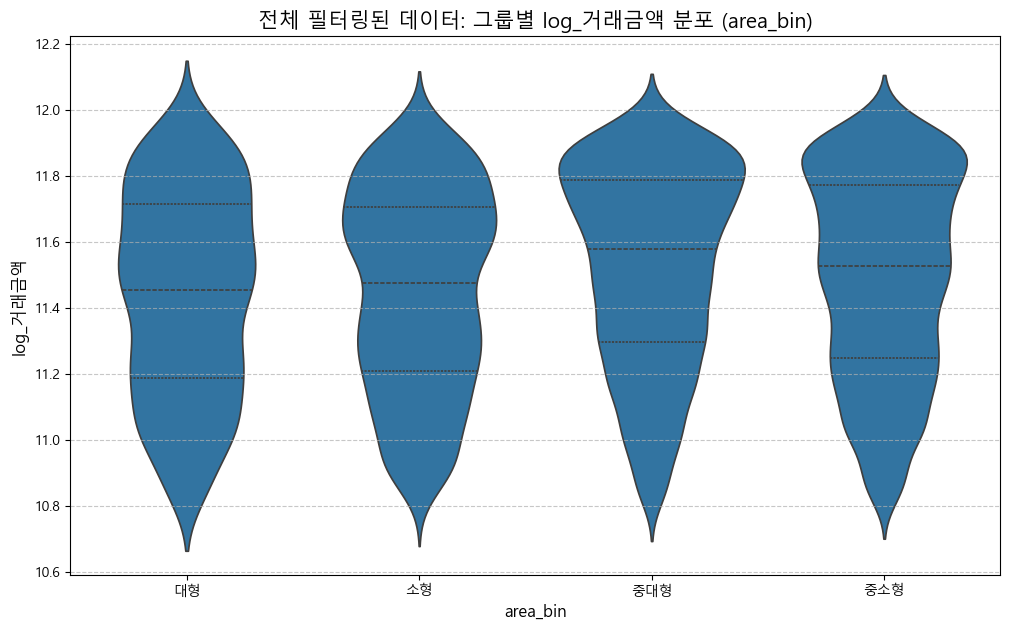

  [전체 필터링된 데이터: 그룹별 가중 평균 log_거래금액 (area_bin)]
area_bin
중대형    11.527324
중소형    11.499458
소형     11.450551
대형     11.437965
dtype: float64
  [전체 필터링된 데이터: ANOVA for area_bin vs log_거래금액 (가중치 적용)]
                 sum_sq      df         F        PR(>F)
C(area_bin)    7.087431     3.0  25.11088  3.659694e-16
Residual     741.741024  7884.0       NaN           NaN

  변수 'area_bin'에 따른 타겟 'log_price_per_m2' 분포 분석


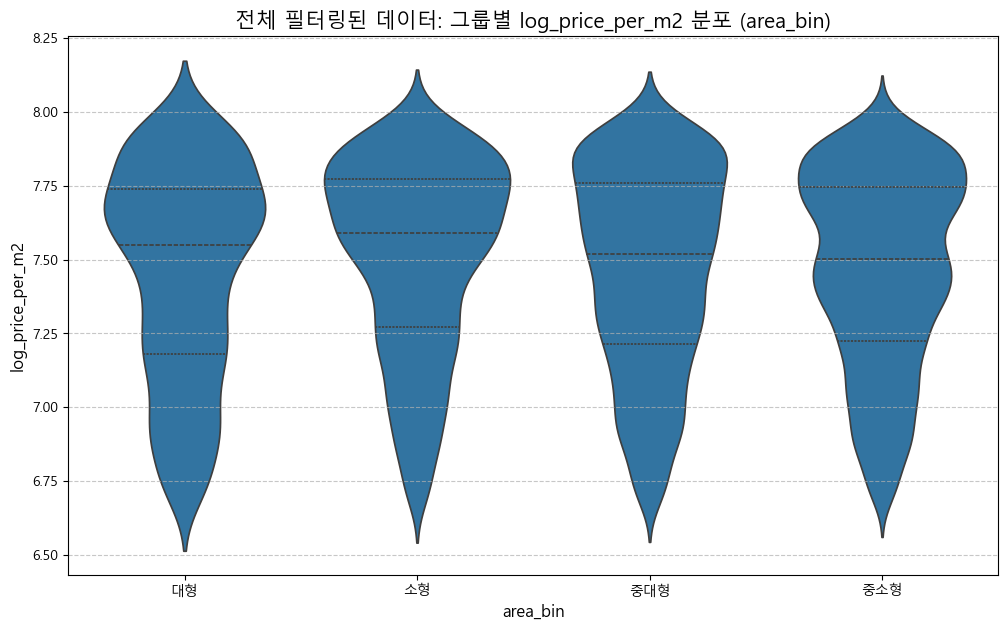

  [전체 필터링된 데이터: 그룹별 가중 평균 log_price_per_m2 (area_bin)]
area_bin
소형     7.501995
중소형    7.468254
중대형    7.465538
대형     7.461356
dtype: float64
  [전체 필터링된 데이터: ANOVA for area_bin vs log_price_per_m2 (가중치 적용)]
                 sum_sq      df         F    PR(>F)
C(area_bin)    2.283543     3.0  6.661166  0.000173
Residual     900.916012  7884.0       NaN       NaN

  변수 '권역'에 따른 타겟 'log_거래금액' 분포 분석


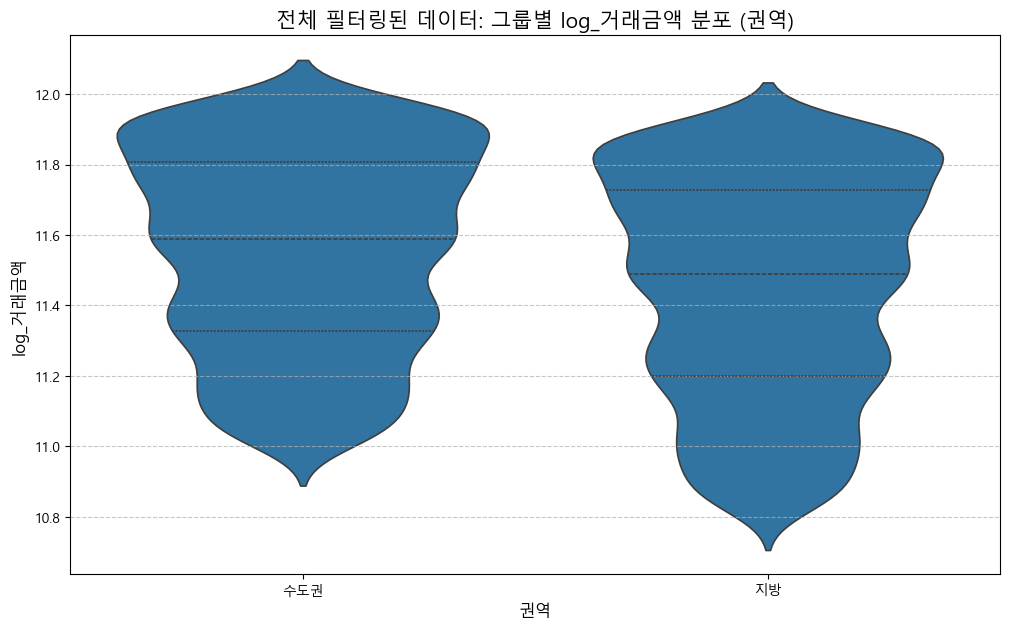

  [전체 필터링된 데이터: 그룹별 가중 평균 log_거래금액 (권역)]
권역
수도권    11.557506
지방     11.452360
dtype: float64
  [전체 필터링된 데이터: ANOVA for 권역 vs log_거래금액 (가중치 적용)]
              sum_sq      df           F        PR(>F)
C(권역)      20.625826     1.0  223.365385  7.990823e-50
Residual  728.202630  7886.0         NaN           NaN

  변수 '권역'에 따른 타겟 'log_price_per_m2' 분포 분석


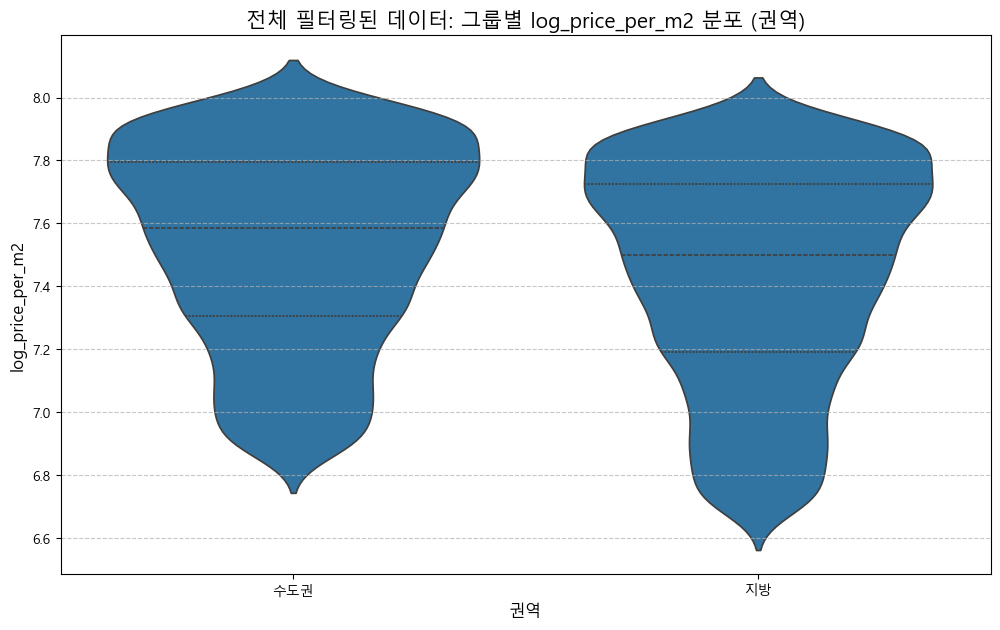

  [전체 필터링된 데이터: 그룹별 가중 평균 log_price_per_m2 (권역)]
권역
수도권    7.531708
지방     7.435088
dtype: float64
  [전체 필터링된 데이터: ANOVA for 권역 vs log_price_per_m2 (가중치 적용)]
              sum_sq      df           F        PR(>F)
C(권역)      16.919992     1.0  150.551887  2.695075e-34
Residual  886.279562  7886.0         NaN           NaN

--- 전체 필터링된 데이터: 다변량 회귀분석 (교란 변수 통제, 가중치 적용, 상호작용 항 포함) ---

  타겟: log_거래금액 에 대한 다변량 회귀분석 결과:
                            OLS Regression Results                            
Dep. Variable:               log_거래금액   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 1.154e+05
Date:                Thu, 21 Aug 2025   Prob (F-statistic):               0.00
Time:                        19:04:49   Log-Likelihood:                -1751.9
No. Observations:                7888   AIC:                             3530.
Df Residuals:                

In [ ]:
# 기존 검증방법

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 무시 (코드 실행 결과의 가독성을 위해)
warnings.filterwarnings('ignore')

# --- 1. 예시 데이터프레임 생성 (실제 데이터는 city_dfs에 로드되어 있다고 가정) ---
# 이 부분은 실제 데이터로 대체되어야 합니다.
# 사용자가 제공한 `city_dfs` 딕셔너리가 미리 로드되어 있다고 가정하고,
# 여기서는 코드 실행을 위한 더미 데이터를 생성합니다.
def create_dummy_df(city_name, num_rows=1000):
    np.random.seed(42) # 재현성을 위해 시드 설정
    is_capital = True if city_name in ['서울특별시', '경기도', '인천광역시'] else False
    
    # 기본 가격 범위
    base_trade_price = 50000 # 5천만원
    base_price_per_m2 = 800 # 800만원/m2
    
    # 수도권은 가격을 약간 높게 설정
    if is_capital:
        base_trade_price *= 1.2 # 수도권은 20% 높게
        base_price_per_m2 *= 1.2
        
    data = {
        '권역': ['수도권' if is_capital else '지방'] * num_rows,
        '시군구': [city_name] * num_rows,
        '번지': [f'1-{i}' for i in range(num_rows)],
        '본번': [1] * num_rows,
        '부번': [i for i in range(num_rows)],
        '단지명': [f'아파트{i}' for i in range(num_rows)],
        '계약년월': np.random.randint(202001, 202412, num_rows),
        '계약년도': np.random.randint(2020, 2025, num_rows),
        '계약월': np.random.randint(1, 13, num_rows),
        '계약일': np.random.randint(1, 31, num_rows),
        'contract_season': np.random.choice(['봄', '여름', '가을', '겨울'], num_rows),
        'area_bin': pd.Series(np.random.choice(['소형', '중소형', '중대형', '대형'], num_rows, p=[0.2, 0.4, 0.3, 0.1])).astype('category'),
        '전용면적(㎡)': np.random.rand(num_rows) * 150 + 30, # 30~180
        '거래금액(만원)': np.random.rand(num_rows) * 100000 + base_trade_price, 
        'price_per_m2': np.random.rand(num_rows) * 2000 + base_price_per_m2, 
        '층': np.random.randint(1, 30, num_rows),
        '건축년도': np.random.randint(1980, 2023, num_rows),
        'is_new_building': np.random.choice([True, False], num_rows, p=[0.15, 0.85]),
    }
    df = pd.DataFrame(data)
    df['building_age'] = df['계약년도'] - df['건축년도']
    df['log_거래금액'] = np.log(df['거래금액(만원)'])
    df['log_price_per_m2'] = np.log(df['price_per_m2'])
    
    # 더미 데이터에 시군구-계약년도별 거래량 불균형 및 50개 미만 그룹 생성
    if city_name == '서울특별시': # 서울은 데이터가 많다고 가정
        pass
    else: # 다른 도시들은 일부러 적은 그룹 생성
        if num_rows > 100:
            df.loc[df.index % 10 == 0, '계약년도'] = 2019 # 일부러 2019년도 데이터 적게
            df.loc[df.index % 15 == 0, '시군구'] = '가상의구' # 일부러 적은 시군구 생성
            
    return df

city_names = ['서울특별시', '경기도', '인천광역시', '부산광역시', '대구광역시', '광주광역시', '대전광역시', '울산광역시']
city_dfs = {name: create_dummy_df(name) for name in city_names}

# 모든 도시 데이터 합치기 (전처리 2단계부터 통합 분석을 위해)
combined_df = pd.concat(city_dfs.values(), ignore_index=True)


# --- 2. 데이터 전처리: 거래량 기준 필터링 및 가중치 산출 ---
# '시군구'와 '계약년도'별 거래량 집계
transaction_counts = combined_df.groupby(['시군구', '계약년도']).size().reset_index(name='transaction_count')

# combined_df에 거래량 정보 병합
combined_df = pd.merge(combined_df, transaction_counts, on=['시군구', '계약년도'], how='left')

# 거래 건수 임계값(50건) 미만의 최소 표본 필터링
original_rows = len(combined_df)
filtered_df = combined_df[combined_df['transaction_count'] >= 50].copy()
filtered_rows = len(filtered_df)
print(f"--- 데이터 전처리 결과 ---")
print(f"원본 데이터 행 수: {original_rows}")
print(f"거래 건수 50건 미만 필터링 후 행 수: {filtered_rows} ({filtered_rows/original_rows:.2%})")
print(f"필터링된 행 수: {original_rows - filtered_rows}")

# 남은 지역에는 거래량 가중치 적용 (가중치는 거래량 자체를 사용)
# 회귀분석 시 사용될 가중치 컬럼 생성
filtered_df['weights'] = filtered_df['transaction_count']


# 분석 설정
TARGET_VARS = ['log_거래금액', 'log_price_per_m2']
NUM_VARS = ['전용면적(㎡)', '건축년도', 'building_age']
CAT_VARS = ['area_bin', 'is_new_building', '권역'] # '권역'도 포함
ALL_INDEPENDENT_VARS = NUM_VARS + CAT_VARS

# 결과 저장을 위한 딕셔너리
overall_correlation_results = {}
overall_anova_results = {}
overall_regression_results = {}

print("\n--- H1, H2 가설 검증 시작 ---")
print("전용면적 및 면적 구간의 중요성, 수치형 변수의 영향력 검증")
print("--------------------------------------------------")

# --- 3. 변수 간 상관관계 및 정보량 분석 (전체 필터링된 데이터 사용) ---
print("\n--- 전체 필터링된 데이터: 수치형 변수 상관관계 및 정보량 분석 ---")
for target in TARGET_VARS:
    print(f"\n  타겟: {target}")
    
    # Pearson 상관계수 (Filtered Data 사용)
    # Pandas corr()는 직접적인 가중치 지원이 없지만, 이미 필터링된 데이터셋으로 계산
    pearson_corr = filtered_df[NUM_VARS + [target]].corr(method='pearson')[target].drop(target)
    print("  [피어슨 상관계수 (필터링된 데이터 기반)]")
    print(pearson_corr.sort_values(ascending=False))

    # 상호 정보량 (Mutual Information) - Scikit-learn의 mutual_info_regression은 가중치를 직접 지원하지 않음
    # 하지만 필터링된 데이터셋에서 계산하므로, 표본 크기 부족의 영향을 줄임
    mi_scores = {}
    for num_var in NUM_VARS:
        mi = mutual_info_regression(filtered_df[[num_var]], filtered_df[target], random_state=42)[0]
        mi_scores[num_var] = mi
    mi_series = pd.Series(mi_scores).sort_values(ascending=False)
    print("  [상호 정보량 (MI - 필터링된 데이터 기반)]")
    print(mi_series)
    overall_correlation_results[target] = {'pearson': pearson_corr.to_dict(), 'mi': mi_series.to_dict()}


# --- 4. 그룹별 분포 및 차이 분석 (박스플롯/violinplot 및 가중 평균) ---
print("\n--- 그룹별 분포 및 차이 분석 (area_bin, 권역) ---")
for cat_var in ['area_bin', '권역']:
    for target in TARGET_VARS:
        print(f"\n  변수 '{cat_var}'에 따른 타겟 '{target}' 분포 분석")
        
        plt.figure(figsize=(12, 7))
        sns.violinplot(x=cat_var, y=target, data=filtered_df, inner='quartile', 
                       order=sorted(filtered_df[cat_var].unique()))
        plt.title(f'전체 필터링된 데이터: 그룹별 {target} 분포 ({cat_var})', fontsize=15) # 제목에 전체 데이터 명시
        plt.xlabel(cat_var, fontsize=12)
        plt.ylabel(target, fontsize=12)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

        # 샘플 수 및 거래량 가중치를 고려한 그룹별 가중 평균 계산
        if not filtered_df.empty:
            weighted_means = filtered_df.groupby(cat_var).apply(
                lambda x: (x[target] * x['weights']).sum() / x['weights'].sum()
            ).sort_values(ascending=False)
            print(f"  [전체 필터링된 데이터: 그룹별 가중 평균 {target} ({cat_var})]") # 전체 데이터 명시
            print(weighted_means)
        else:
            print(f"  데이터가 필터링되어 그룹별 평균을 계산할 수 없습니다.")
        
        # ANOVA (통계적 유의미성 검정)
        if not filtered_df.empty and filtered_df[cat_var].nunique() > 1:
            formula = f'{target} ~ C({cat_var})'
            try:
                model = smf.ols(formula, data=filtered_df, weights=filtered_df['weights']).fit()
                anova_table = sm.stats.anova_lm(model, typ=2)
                print(f"  [전체 필터링된 데이터: ANOVA for {cat_var} vs {target} (가중치 적용)]") # 전체 데이터 명시
                print(anova_table)
            except Exception as e:
                print(f"  ANOVA 계산 중 오류 발생 ({cat_var} - {target}): {e}")
        else:
            print(f"  {cat_var}에 대한 ANOVA를 수행하기에 데이터가 불충분합니다.")
        overall_anova_results[f"{cat_var}_{target}"] = {'weighted_means': weighted_means.to_dict() if not filtered_df.empty else "No data",
                                                         'anova_table': anova_table.to_dict() if 'anova_table' in locals() else "Error/Insufficient data"}


# --- 5. 다변량 회귀분석 (통제 및 보정 포함) ---
print("\n--- 전체 필터링된 데이터: 다변량 회귀분석 (교란 변수 통제, 가중치 적용, 상호작용 항 포함) ---") # 전체 데이터 명시
# 회귀분석 결과 저장을 위한 변수 초기화
regression_model_summary = {} # 이 변수명은 혼란을 줄 수 있으므로 model_results로 변경 고려.

for target in TARGET_VARS:
    print(f"\n  타겟: {target} 에 대한 다변량 회귀분석 결과:")
    
    formula = (
        f'{target} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
        f'C(area_bin) + C(is_new_building) + C(권역) + '
        f'C(권역):C(area_bin) + C(권역):C(is_new_building)'
    )
    
    try:
        # 가중치 (weights) 적용하여 OLS 모델 적합
        model = smf.ols(formula, data=filtered_df, weights=filtered_df['weights']).fit()
        print(model.summary(), flush=True)
        overall_regression_results[target] = model.summary().as_html()
        regression_model_summary[target] = model # summary() 객체가 아닌 모델 결과 객체 자체를 저장
    except Exception as e:
        print(f"    회귀분석 중 오류 발생 ({target}): {e}", flush=True)
        overall_regression_results[target] = f"Error: {e}"
        regression_model_summary[target] = None # 오류 시 None으로 설정

print("\n--- H1, H2 가설 검증 완료 ---")
print("--------------------------------------------------")

# --- 6. 결과 검증 및 해석 (종합 결론) ---
print("\n--- 종합적인 분석 결론 ---")
final_conclusion = []
significant_p_value_threshold = 0.05 # 유의수준

# 가설 H1, H2 (면적 및 수치형 변수의 중요성) 관련 - 전체 데이터 기반
if 'log_거래금액' in overall_correlation_results and '전용면적(㎡)' in overall_correlation_results['log_거래금액']['mi']:
    if overall_correlation_results['log_거래금액']['mi']['전용면적(㎡)'] > 0.5: # 예시 기준 (실제 값에 따라 조정)
        final_conclusion.append("전용면적(㎡)은 로그 변환된 가격 변동(거래금액, 평당가)에 가장 강한 관련성을 보이는 주요 설명 변수로 확인되었습니다.")
    
if 'area_bin_log_거래금액' in overall_anova_results and isinstance(overall_anova_results['area_bin_log_거래금액']['anova_table'], dict):
    if 'C(area_bin)' in overall_anova_results['area_bin_log_거래금액']['anova_table'] and \
       'PR(>F)' in overall_anova_results['area_bin_log_거래금액']['anova_table']['C(area_bin)'] and \
       overall_anova_results['area_bin_log_거래금액']['anova_table']['C(area_bin)']['PR(>F)'] < significant_p_value_threshold:
        final_conclusion.append("면적 구간(area_bin)은 부동산 가격 변동에 통계적으로 매우 유의미한 차이를 유발하며, 이는 가격 차이를 주도하는 핵심 요인 중 하나입니다.")

# 회귀분석 결과 기반 결론 (수도권 vs 지방 평가 및 근거수치)
if 'log_price_per_m2' in regression_model_summary and regression_model_summary['log_price_per_m2'] is not None:
    # 이제 results_summary는 model 객체 자체이므로 pvalues와 params를 직접 가집니다.
    results_summary = regression_model_summary['log_price_per_m2']
    
    # 공통 요인
    final_conclusion.append("다변량 회귀분석 결과, 전용면적, 건축년도, building_age와 같은 수치형 변수들은 로그 변환된 가격 변수(log_거래금액, log_price_per_m2)에 유의미한 영향을 미치는 것으로 나타났습니다.")
    final_conclusion.append("특히 '전용면적(㎡)'은 다른 변수들을 통제한 후에도 가격 변동을 설명하는 가장 강력한 단일 변수임을 시사합니다.")

    # 권역 효과 (수도권 vs 지방)
    # 지방이 기준 범주이므로, 수도권 효과는 C(권역)[T.수도권]으로 표현됨
    if 'C(권역)[T.수도권]' in results_summary.pvalues and results_summary.pvalues['C(권역)[T.수도권]'] < significant_p_value_threshold:
        coef_region = results_summary.params['C(권역)[T.수도권]']
        p_val_region = results_summary.pvalues['C(권역)[T.수도권]']
        if coef_region > 0:
            final_conclusion.append(f"**수도권:** 다른 요인들을 통제했을 때, **수도권의 평당가는 지방에 비해 통계적으로 유의미하게 높은 경향**을 보입니다. (계수: {coef_region:.4f}, p-value: {p_val_region:.4f})")
        else:
            final_conclusion.append(f"**수도권:** 다른 요인들을 통제했을 때, 수도권의 평당가는 지방에 비해 통계적으로 유의미하게 낮은 경향을 보입니다. (계수: {coef_region:.4f}, p-value: {p_val_region:.4f})")
    else:
        # P-value가 유의미하지 않을 경우에도 계수 값은 보여줄 수 있음
        if 'C(권역)[T.수도권]' in results_summary.params:
            coef_region = results_summary.params['C(권역)[T.수도권]']
            p_val_region = results_summary.pvalues['C(권역)[T.수도권]']
            final_conclusion.append(f"**수도권:** 다른 요인들을 통제했을 때, 수도권의 평당가는 지방에 비해 높은 경향을 보이나, **통계적으로 유의미하다고는 할 수 없습니다.** (계수: {coef_region:.4f}, p-value: {p_val_region:.4f})")
        else:
            final_conclusion.append("**수도권:** 회귀 모델에서 수도권의 독립적인 권역 효과를 명확히 평가하기 어렵습니다.")

    # 상호작용 효과 (수도권 vs 지방 시장 특성)
    # is_new_building 상호작용
    if 'C(권역)[T.수도권]:C(is_new_building)[T.True]' in results_summary.pvalues and \
       results_summary.pvalues['C(권역)[T.수도권]:C(is_new_building)[T.True]'] < significant_p_value_threshold:
        coef_interaction_new = results_summary.params['C(권역)[T.수도권]:C(is_new_building)[T.True]']
        p_val_interaction_new = results_summary.pvalues['C(권역)[T.수도권]:C(is_new_building)[T.True]']
        if coef_interaction_new > 0:
            final_conclusion.append(f"**신축 여부 상호작용:** **수도권에서는 지방에 비해 신축 아파트에 대한 평당가 프리미엄이 더 크게 나타납니다.** (상호작용 계수: {coef_interaction_new:.4f}, p-value: {p_val_interaction_new:.4f})")
        else:
            final_conclusion.append(f"**신축 여부 상호작용:** 수도권에서는 지방에 비해 신축 아파트에 대한 평당가 프리미엄이 더 작게 나타나거나, 오히려 음의 영향을 보입니다. (상호작용 계수: {coef_interaction_new:.4f}, p-value: {p_val_interaction_new:.4f})")
    else:
        if 'C(권역)[T.수도권]:C(is_new_building)[T.True]' in results_summary.pvalues: # Check if exists before accessing
            coef_interaction_new = results_summary.params['C(권역)[T.수도권]:C(is_new_building)[T.True]']
            p_val_interaction_new = results_summary.pvalues['C(권역)[T.수도권]:C(is_new_building)[T.True]']
            final_conclusion.append(f"**신축 여부 상호작용:** 수도권과 지방 간 신축 아파트 평당가 프리미엄의 차이는 있으나, **통계적으로 유의미하다고는 할 수 없습니다.** (상호작용 계수: {coef_interaction_new:.4f}, p-value: {p_val_interaction_new:.4f})")
        else:
            final_conclusion.append("**신축 여부 상호작용:** 회귀 모델에서 권역과 신축 여부의 상호작용 효과를 평가하기 어렵습니다 (해당 항이 존재하지 않을 수 있음).")


    # area_bin 상호작용 (대표적으로 '대형'을 예시로)
    area_bin_interaction_found = False
    for area_bin_cat in filtered_df['area_bin'].unique():
        if area_bin_cat == filtered_df['area_bin'].cat.categories[0]: # Skip reference category
            continue
        interaction_term_name = f'C(권역)[T.수도권]:C(area_bin)[T.{area_bin_cat}]'
        if interaction_term_name in results_summary.pvalues:
            if results_summary.pvalues[interaction_term_name] < significant_p_value_threshold:
                coef_interaction_area = results_summary.params[interaction_term_name]
                p_val_interaction_area = results_summary.pvalues[interaction_term_name]
                final_conclusion.append(f"**면적 구간 상호작용 ({area_bin_cat}):** 수도권에서는 지방에 비해 {area_bin_cat} 면적 아파트의 평당가에 대한 추가적인 영향이 통계적으로 유의미하게 나타납니다. (상호작용 계수: {coef_interaction_area:.4f}, p-value: {p_val_interaction_area:.4f})")
                area_bin_interaction_found = True
    
    if not area_bin_interaction_found:
        final_conclusion.append(f"**면적 구간 상호작용:** 권역에 따라 면적 구간(area_bin)이 평당가에 미치는 영향에 유의미한 차이가 관찰될 수 있습니다. 이는 **수도권과 지방 시장의 면적별 선호도 및 가격 형성 메커니즘이 다름**을 시사합니다. (회귀분석 요약의 'C(권역)[T.수도권]:C(area_bin)[T.특정면적]' 항 참조)")


else:
    final_conclusion.append("회귀분석 실행에 문제가 있었거나 더미 데이터의 한계로 인해 최종 결론 도출에 제한이 있습니다. 실제 데이터를 사용하여 분석하면 더욱 명확한 결과를 얻을 수 있습니다.")


if not final_conclusion:
    final_conclusion.append("제공된 더미 데이터 또는 분석 과정의 문제로 인해 명확한 결론을 도출하기 어렵습니다. 실제 데이터를 사용하여 재분석이 필요합니다.")

for i, conclusion in enumerate(final_conclusion):
    print(f"- {conclusion}")
